<a href="https://colab.research.google.com/github/mavy731/UIUC-MSFE-FALL20-IE525/blob/main/Project_1/Pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://news.illinois.edu/files/6367/543635/116641.jpg" alt="University of Illinois" width="250"/>

## Project 1: Pairs Trading ##

### Due 2021-Feb-05 23:59:59 CST###

Project submission by group (optimally 4 people, please list all your group members below, with names and email addresses)
* Junye Qiu <junyeq2@illinois.edu>
* Dong Zhu <dongzhu2@illinois.edu>
* Yue Ma <yuema4@illinois.edu>


Note 0:  Anaconda Python <https://www.anaconda.com/distribution/> is a strong implementation of python.

Note 1: Suggest using Google Colab to work in groups. Google colab is a sharable type of Jupyter Notebook. To work on google colab, first save a copy of this file to your own drive using **File>Save a copy in Drive** and share the saved copy among group members. (Be sure to log on Google colab and Google Drive with your Illinois Google account. Please refer to https://itservices.illinois.edu/services/google-apps-illinois/details for more information of your Illinois Google account).

Note 2: For submission, please do the following two steps, both before the due time **(late submissions are not acceptable)**:

*   Download the finished notebook as an **.ipynb** file and upload the file to Gradescope (one upload per group will be enough, please ignore the Autograder if you see it when uploading)
*   (If using Google Colab) Send a sharable link to me via email: <qiz2@illinois.edu> (one email per group will be enough)



### imports and graphics configurations ###

In [ ]:
import numpy as np
import pandas
import time
import random
import matplotlib
#%matplotlib notebook
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib.offsetbox as offsetbox
from matplotlib.ticker import StrMethodFormatter

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def saver(fname):
    plt.savefig(fname+".png",bbox_inches="tight")
    
def legend(pos="bottom",ncol=3,extra=False):
    if pos=="bottom":
        extra = 0.15 if extra else 0
        plt.legend(bbox_to_anchor=(0.5,-0.2-extra), loc='upper center',facecolor="lightgray",ncol=ncol)
    elif pos=="side":
        plt.legend(bbox_to_anchor=(1.1,0.5), loc='center left',facecolor="lightgray",ncol=1)
        
def textbox(txt,fname=None):
    plt.figure(figsize=(1,1))
    plt.gca().add_artist(offsetbox.AnchoredText("\n".join(txt), loc="center",prop=dict(size=30)))
    plt.axis('off')
    if fname is not None:
        saver(fname)
    plt.show()
    plt.close()

def getfile(location_pair,**kwargs): #tries to get local version and then defaults to google drive version
    (loc,gdrive)=location_pair
    try:
        out=pandas.read_csv(loc,**kwargs)
    except FileNotFoundError:
        print("local file not found; accessing Google Drive")
        loc = 'https://drive.google.com/uc?export=download&id='+gdrive.split('/')[-2]
        out=pandas.read_csv(loc,**kwargs)
    return out

In [ ]:
#for some reason, this needs to be in a separate cell
params={
    "font.size":15,
    "lines.linewidth":5,
}
plt.rcParams.update(params)

# **Pairs Trading (30 pts)** #

Please use the data (Jan-02-2019 to Dec-30-2020) for General Motors Company (NYSE: GM) and Ford Motor Company (NTSE: F) to complete the following two tasks. 

Data for Ford: https://drive.google.com/file/d/1_GprTKCcZH6S3cuWdGJoQHTmS4YuKWpM/view?usp=sharing 

Data for GM: https://drive.google.com/file/d/14gL6c8rDCKIH6zdoN4Vl1w8DZMXOlF2y/view?usp=sharing

(Data Source: Yahoo Finance)

###Read in date###

In [ ]:
ticker_A="F"
filedata_A=(ticker_A+".csv","https://drive.google.com/file/d/1_GprTKCcZH6S3cuWdGJoQHTmS4YuKWpM/view?usp=sharing")


ticker_B="GM"
filedata_B=(ticker_B+".csv","https://drive.google.com/file/d/14gL6c8rDCKIH6zdoN4Vl1w8DZMXOlF2y/view?usp=sharing")

color_A="red"
color_B="blue"

data_A=getfile(filedata_A).set_index("Date",drop=True)
data_A.index = pandas.to_datetime(data_A.index)
print(data_A.head(10))
adj_A=pandas.Series(data_A["Adj Close"],name=ticker_A)

data_B=getfile(filedata_B).set_index("Date",drop=True)
data_B.index = pandas.to_datetime(data_B.index)
print(data_B.head(10))
adj_B=pandas.Series(data_B["Adj Close"],name=ticker_B)

local file not found; accessing Google Drive
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2019-01-02  7.53  8.02  7.48   7.90   7.157524  47494400
2019-01-03  7.97  7.99  7.78   7.78   7.048802  39172400
2019-01-04  7.91  8.12  7.85   8.08   7.320606  43039800
2019-01-07  8.11  8.37  8.03   8.29   7.510870  40729400
2019-01-08  8.42  8.54  8.35   8.37   7.583352  45644000
2019-01-09  8.45  8.77  8.36   8.72   7.900456  48404900
2019-01-10  8.71  8.77  8.45   8.67   7.855156  39490400
2019-01-11  8.77  8.93  8.70   8.82   7.991058  41559900
2019-01-14  8.80  9.06  8.76   8.99   8.145081  44833800
2019-01-15  9.02  9.03  8.75   8.84   8.009178  65311700
local file not found; accessing Google Drive
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2019-01-02  32.849998  33.810001  32.410000  33.639999  31.893360   766230

##Task 1##

**Task 1 (Cointegration):** Is it better to regress F on GM, or GM on F?  This is an open-ended question with no fixed correct answer. I wish you to investigate, come to a conclusion, and defend it. Please include code and also your analysis. (15 pts)

###Regress GM on F###

slope: 3.5729920014660546
intercept: 5.019331144153952
r-squared: 0.7856526558299828
MAPE: 0.061187539525645346
Date
2019-01-02    1.300253
2019-01-03    0.370889
2019-01-04    0.423657
2019-01-07    0.720367
2019-01-08    0.888030
Name: residual, dtype: float64


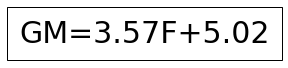

In [ ]:
slope, intercept, r_value1,_,_= scipy.stats.linregress(
    adj_A,adj_B)
print("slope: "+str(slope))
print("intercept: "+str(intercept))
print("r-squared: "+str(r_value1**2))
residual=adj_B-(intercept+adj_A*slope)
print("MAPE: "+str(np.mean(np.abs(residual)/adj_B)))
residual.name="residual"
print(residual.head())

text=[]
text.append("{0:}={1:.2f}{2:}{3:+.2f}".format(ticker_B,slope,ticker_A,intercept))
textbox(text,"regress_formula")


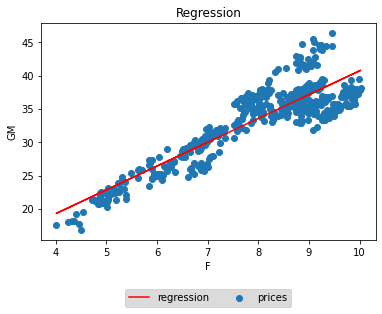

In [ ]:
plt.scatter(adj_A,adj_B,label="prices")
plt.plot(adj_A,intercept+adj_A*slope,color="red",label="regression")
plt.xlabel(ticker_A)
plt.ylabel(ticker_B)
plt.title("Regression")
legend("bottom")
saver("regression1")
plt.show()
plt.close()

###Regress F on GM###





slope: 0.21988648603400657
intercept: 0.593925632105254
r-squared: 0.7856526558299828
MAPE: 0.054946514278794836
Date
2019-01-02   -0.449320
2019-01-03   -0.268270
2019-01-04   -0.221613
2019-01-07   -0.246073
2019-01-08   -0.267403
Name: residual, dtype: float64


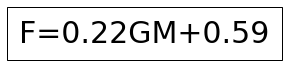

In [ ]:
slope2, intercept2, r_value2,_,_= scipy.stats.linregress(
    adj_B,adj_A)
print("slope: "+str(slope2))
print("intercept: "+str(intercept2))
print("r-squared: "+str(r_value2**2))
print("MAPE: "+str(np.mean(np.abs(residual2)/adj_A)))
residual2=adj_A-(intercept2+adj_B*slope2)
residual2.name="residual"
print(residual2.head())

text=[]
text.append("{0:}={1:.2f}{2:}{3:+.2f}".format(ticker_A,slope2,ticker_B,intercept2))
textbox(text,"regress_formula")


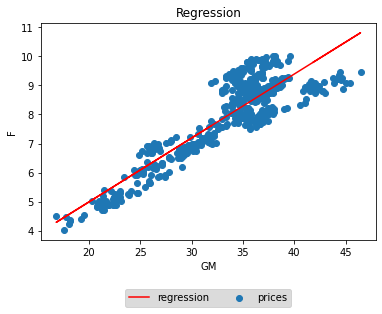

In [ ]:
plt.scatter(adj_B,adj_A,label="prices")
plt.plot(adj_B,intercept2+adj_B*slope2,color="red",label="regression")
plt.xlabel(ticker_B)
plt.ylabel(ticker_A)
plt.title("Regression")
legend("bottom")
saver("regression2")
plt.show()
plt.close()

###Conclusion###

Since these two models have very close $R^{2}$ and $MAPE$, they are at similar level in terms of model valuation. We would prefer regress GM on F for following reasons.






##Task 2##

**Task 2 (Backtesting):** Construct a pairs trading strategy F on GM from 2019 data.  Test how it works on 2020 data. (15 pts)

###Regression F on GM using 2019 data###

slope: 0.1012248916326303
intercept: 5.139556647360986
r-squared: 0.05541768621984326
Date
2019-01-02   -1.210435
2019-01-03   -1.185760
2019-01-04   -1.017602
2019-01-07   -0.926186
2019-01-08   -0.896891
Name: residual, dtype: float64


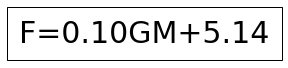

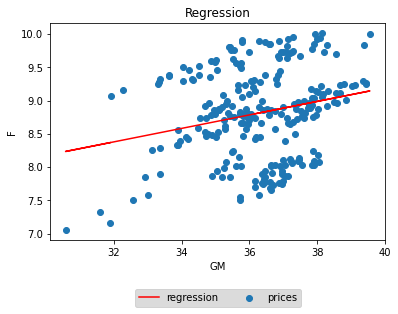

In [ ]:
A19=adj_A.loc['2019-01-02':'2019-12-31']
A20=adj_A.loc['2020-01-02':'2020-12-31']

B19=adj_B.loc['2019-01-02':'2019-12-31']
B20=adj_B.loc['2020-01-02':'2020-12-31']

slope, intercept, r_value1,_,_= scipy.stats.linregress(
    B19,A19)
print("slope: "+str(slope))
print("intercept: "+str(intercept))
print("r-squared: "+str(r_value1**2))
residual=A19-(intercept+B19*slope)
residual.name="residual"
print(residual.head())

text=[]
text.append("{0:}={1:.2f}{2:}{3:+.2f}".format(ticker_A,slope,ticker_B,intercept))
textbox(text,"regress_formula")

plt.scatter(B19,A19,label="prices")
plt.plot(B19,intercept+B19*slope,color="red",label="regression")
plt.xlabel(ticker_B)
plt.ylabel(ticker_A)
plt.title("Regression")
legend("bottom")
saver("regression1")
plt.show()
plt.close()


###Testing on 2020 data###

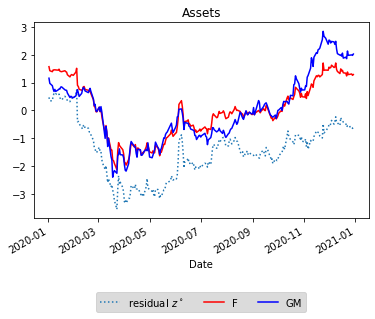

In [ ]:
residual=A20-(intercept+B20*slope)
normalized_A=A20/A20[0]
normalized_B=B20/B20[0]
plt.figure()
plt.plot(residual.index,residual/residual.std(),label=r"residual $z^\circ$",linestyle="dotted")
plt.plot(normalized_A.index,(normalized_A-normalized_A.mean())/normalized_A.std(),label=ticker_A,color=color_A)
plt.plot(normalized_B.index,(normalized_B-normalized_B.mean())/normalized_A.std(),label=ticker_B,color=color_B)
#plt.ylabel("")
plt.xlabel("Date")
plt.title("Assets")
plt.gcf().autofmt_xdate()
legend("bottom",extra=True)
saver("assets")
plt.show()
plt.close()

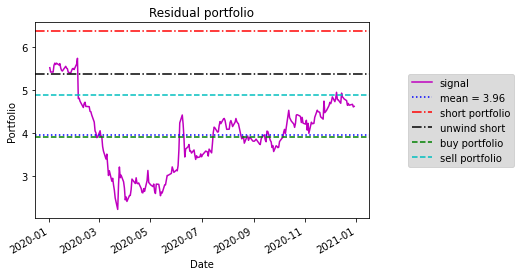

In [ ]:
residual_mean=residual.mean()
residual_std=residual.std()
plt.figure()
plt.plot(residual.index,residual+intercept,label="signal",color="m")
plt.axhline(residual_mean+intercept,color="blue",linestyle=":",label="mean = {:.2f}".format(residual_mean+intercept))
plt.axhline(intercept+1.5*residual_std,color="red",linestyle="-.",label="short portfolio")
plt.axhline(intercept+0.3*residual_std,linestyle="-.",color="black",label="unwind short")
plt.axhline(intercept-1.5*residual_std,color="green",linestyle="--",label="buy portfolio")
plt.axhline(intercept-0.3*residual_std,linestyle="--",color="c",label="sell portfolio")
plt.ylabel("Portfolio")
plt.xlabel("Date")
title=[]
title.append("Residual portfolio")
plt.title("\n".join(title))
plt.gcf().autofmt_xdate()
legend("side")
saver("residual_strategy")
plt.show()
plt.close()